### Лабораторная работа № 2. Сравнение различных подходов к хешированию.

**Целью** данной работы является сравнение различных методов борьбы с коллизиями:

1) Метод цепочек;

2) Метод открытой адресации (см. Кормен, 3-е издание, 11.4 Открытая адреация);

3) Метод кукушки (см. https://en.wikipedia.org/wiki/Cuckoo_hashing).

4) Для интереса, предлагается также сделать сравнения со стандартными средствами языка c++: std::map, std::hash_map. Вдруг получится их обогнать.

*Замечание:* В качестве хеш-функций используйте только функции из универсальных
семейств, про них рассказывалось на семинарах. Список универсальных хеш-функций
можно найти здесь https://en.wikipedia.org/wiki/Universal_hashing.

**Что измеряется?**

1) Время вставки;

2) Время удаления;

3) Время поиска.

Более конкретно об измерении:

Нужно выбрать какое-то стартовое значение N, скажем 100, выбрать шаг step, скажем пусть
step = 100, и выбрать максимальное значение, скажем 100 000. После чего нужно для каждого
N с шагом step от минимального значения до максимального построить таблицу размера N
(из случайных элементов, или сделать выборку из заранее подготовленной базы) и
произвести одну или несколько операций (если несколько, скажем 10, то нужно усреднить).
Измеряем именно время одной операции. Некоторые допускают ошибку и делают N вставок
с замером времени, но не понятно, что в итоге Вы измерили.

**Входные данные:**

a) Случайные натуральные числа.

б) Случайные вектора или строки.

с) Очень бы хотелось увидеть как поведут себя таблицы на real life данных, например на словарях или словах какого нибудь литературного произведения.

**Ваш вывод должен содержать:**

1) График зависимости скорости вставки от количества элементов в таблице;

2) График зависимости скорости удаления от количества элементов в таблице;

3) График зависимости скорости поиска от количества элементов в таблице;

На каждом графике должно быть несколько кривых, по одной или больше для каждого
подхода. Заметим также, что таблицы из подходов 1) и 2) имеют дополнительный параметр m
– ёмкость таблицы. Хорошо бы построить на графиках кривые для разных значений m,
например m = 2n, m = n, m = ½ n. Но это не обязательно.

In [151]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import copy

# Рандом

In [152]:
class RandomIntGenerator:
  def __init__(self, max_value=1000):
    self.max_value = max_value

  def __str__(self):
    return 'Random Int Generator'

  def __call__(self):
    return random.randint(0, self.max_value)
     
        
class RandomTupleGenerator:
  def __init__(self, tuple_size=10, max_value=1000):
    self.tuple_size = tuple_size
    self.max_value = max_value

  def __str__(self):
    return 'Random Tuple Generator'

  def __call__(self):
    tuple_of_numbers = []
    for _ in range(self.tuple_size):
      tuple_of_numbers.append(random.randint(0, self.max_value))
    return tuple(tuple_of_numbers)


# формируем строки из заглавных букв анлглийского алфавита
class RandomStringGenerator:
  def __init__(self, len_string=100, ascii_start_alphabet=65, ascii_end_alphabet=90):
    self.len_string = len_string
    self.ascii_start_alphabet = ascii_start_alphabet
    self.ascii_end_alphabet = ascii_end_alphabet

  def __str__(self):
    return 'Random String Generator'

  def __call__(self):
    string = ''
    for _ in range(self.len_string):
      string += chr(random.randint(self.ascii_start_alphabet, self.ascii_end_alphabet)) 
    return string

# Хэш-функция

В качестве хэш-функции используем функциии из универсальных семейств. 

In [153]:
# P - простое, P >> table size
class HashFunction:
  def __init__(self, p=2**31-1, k=1): # k + 1 independens hash-function
    self.p = p
    self.k = k
    self.a = [random.randint(0, self.p - 1) for _ in range(self.k)]
    self.b = random.randint(1, self.p - 1)

  def __call__(self, key):
    if isinstance(key, int):
      #return (self.a[0] * key + self.b) % self.p
      return (sum([(key ** i) * a_i for i, a_i in enumerate(self.a, 1)]) + self.b) % self.p
    
    elif isinstance(key, tuple):
      #return sum([(self.a[0] ** i) * v for i, v in enumerate(key)]) % self.p
      key = int(sum(key))
      return self(key)
    
    elif isinstance(key, str):
      #hash_value = 0
      #for chr in key:
      #  hash_value = (hash_value * self.a[0] + ord(chr)) % self.p
      #return hash_value
      key = sum([ord(char) for char in key])
      return self(key)

# Цепочки

In [154]:
class ChainHashing():
  class Node(): # нода - односвязный список (необходимо для эффективного удаления)
    def __init__(self, key, next_node=None):
      self.key = key
      self.next_node = next_node


  def __init__(self, size_table=0, hash_function=None):
    self.table = np.zeros(size_table, dtype=object)
    self.hash_function = hash_function
    self.size_table = size_table
    self.n_elements = 0
  

  def __str__(self):
    return "Chain Hashing Method"


  def get_hash(self, key):
    return (self.hash_function(key) % self.size_table)


  def insert(self, key):
    hash_value = self.get_hash(key)
    if self.table[hash_value] == 0:
      self.table[hash_value] = ChainHashing.Node(key)
    else:
      node = self.table[hash_value]
      while node.next_node is not None:
          node = node.next_node
      node.next_node = ChainHashing.Node(key)
    self.n_elements += 1
    return True


  def search(self, key):
    hash_value = self.get_hash(key)
    if self.table[hash_value] != 0:
      node = self.table[hash_value]
      if node.key == key:
        return True
      else: # если попали в случай коллизии - идем по цепочке                  
        node = node.next_node
        while node is not None:
          if node.key == key:
            return True
          node = node.next_node
    return False
  

  def delete(self, key):
    hash_value = self.get_hash(key)
    if self.table[hash_value] != 0:
      node = self.table[hash_value]            
      prev_node = None
      while node is not None:
        if node.key == key:
          if prev_node is None:
            # delete first element
            if node.next_node is None:
                self.table[hash_value] = 0
            else:
                self.table[hash_value] = node.next_node
          else:
            prev_node.next_node = node.next_node
          self.n_elements -= 1
          break
        prev_node = node
        node = node.next_node

# Открытая адресация

In [36]:
class OpenAddressingLinearHashing():
  class Node():
    def __init__(self, key, deleted=False):
      self.key = key
      self.deleted = deleted

  def __init__(self, size_table=0, hash_function=None):
    self.table = np.zeros(size_table, dtype = object)
    self.size_table = size_table
    self.hash_function = hash_function
    self.n_elements = 0
    if hash_function is not None:
      self.p = hash_function.p
      self.k = hash_function.k
      self.hash_function2 = HashFunction(p=self.p, k=self.k)

  def __str__(self):
    return "Open Linear Hashing"

  def get_hash(self, key):
    return self.hash_function(key) % self.size_table

  def probing(self, hash_value, i):
    return (hash_value + i) % self.size_table

  def insert(self, key):
    if self.n_elements == self.size_table:
      self.rehash()
    hash_value = self.get_hash(key)
    i = 0
    new_hash_value = self.probing(hash_value, i)
    while i < self.size_table:
      if self.table[new_hash_value] == 0 or self.table[new_hash_value].deleted:
        self.table[new_hash_value] = OpenAddressingLinearHashing.Node(key)
        self.n_elements += 1
        return True
      i += 1
      new_hash_value = self.probing(hash_value, i)
    return False


  def search(self, key):
    hash_value = self.get_hash(key)
    if self.table[hash_value] == 0:
      return False
    elif (self.table[hash_value].key == key and not self.table[hash_value].deleted):
      return True
    else:
      for i in range(1, self.size_table):
        new_hash_value = self.probing(hash_value, i)
        if self.table[new_hash_value] == 0:
          return False
        elif (self.table[new_hash_value].key == key and not self.table[hash_value].deleted):
          return True
    return False

  
  def delete(self, key):
    hash_value = self.get_hash(key)
    if self.table[hash_value] == 0:
      return False
    elif self.table[hash_value].key == key:
      self.table[hash_value].deleted = True
      self.n_elements -= 1
      return True
    else:
      for i in range(1, self.size_table):
        new_hash_value = self.probing(hash_value, i)
        if self.table[new_hash_value] == 0:
          return False
        elif (self.table[new_hash_value].key == key and not self.table[hash_value].deleted):
          self.table[new_hash_value].deleted = True
          self.n_elements -= 1
          return True
    return False


  def rehash(self, size_coeff=2):
    new_hash_table = type(self)(size_table=self.size_table * size_coeff, 
                                hash_function=HashFunction(p=self.p, k=self.k))
    for i in range(self.size_table):
        key = self.table[i]
        if key != 0:
            new_hash_table.insert(key.key)
    self.__dict__.update(new_hash_table.__dict__)


class OpenAddressingQuadraticHashing(OpenAddressingLinearHashing):    
  def probing(self, hash_value, i, c1=1/2, c2=1/2):
    return (int)((hash_value + c1 * i + c2 * i ** 2) % self.size_table)

  def __str__(self):
    return "Open Quadratic Hashing"


class OpenAddressingDoubleHashing(OpenAddressingLinearHashing):    

    def probing(self, hash_value, i):
        new_hash_value = self.hash_function2(hash_value)
        new_hash_value = 2 * (new_hash_value // 2) - 1 if new_hash_value != 0 else 1
        return (hash_value + i * new_hash_value) % self.size_table

    def __str__(self):
     return "Open Double Hashing" 

# Кукушка

In [155]:
# size_table >= 2n
class CuckooHashing():
  def __init__(self, size_table=0, hash_function1=None, hash_function2=None):
    self.size_table = size_table
    self.table1 = np.zeros(size_table, dtype = object)
    self.table2 = np.zeros(size_table, dtype = object)
    self.n_elements = [0] * 2
    self.hash_function1 = hash_function1
    self.hash_function2 = hash_function2
    self.iter_limit =  (int)(np.log2(self.size_table // 2))   # O(6 * log_2(n)), n = size_table // 2
    
    if hash_function1 is not None:
      self.p = hash_function1.p
      self.k = hash_function1.k


  def __str__(self):
    return "Cuckoo Hashing Method"


  def get_hash1(self, key):
    return (self.hash_function1(key) % self.size_table)


  def get_hash2(self, key):
      return (self.hash_function2(key) % self.size_table)


  def insert(self, key):
    hash_value1 = self.get_hash1(key)

    if self.search(key): # элемент уже есть в одной из таблиц
      return False
    
    curr_table = self.table1
    curr_position = hash_value1

    for _ in range(self.iter_limit):
      if curr_table[curr_position] == 0:
        curr_table[curr_position] = key
        if curr_position == hash_value1:
          self.n_elements[0] += 1
        else:
          self.n_elements[1] += 1
        return True
      # if slot is not empty, kick out old key and replaced it with query key
      key, curr_table[curr_position] = curr_table[curr_position], key
      # search new slot for kicked out key
      if curr_position == hash_value1:
          hash_value2 = self.get_hash2(key)
          curr_position = hash_value2
          curr_table = self.table2
      else:
          hash_value1 = self.get_hash1(key)
          curr_position = hash_value1
          curr_table = self.table1
    #print(self.table1)
    #print(self.table2)
    #print(key)
    #print(self.table1[self.get_hash1(key)], self.table2[self.get_hash2(key)])
    self.rehash()
    return self.insert(key)
  

  def rehash(self):
    new_hash_table = CuckooHashing(size_table=self.size_table, 
                         hash_function1 = HashFunction(p=self.p, k=self.k), 
                         hash_function2 = HashFunction(p=self.p, k=self.k))
    for i in range(self.size_table):
      key1 = self.table1[i]
      if key1 != 0:
          new_hash_table.insert(key1)

      key2 = self.table2[i]
      if key2 != 0:
          new_hash_table.insert(key2)
          
    self.__dict__.update(new_hash_table.__dict__)


  def search(self, key):
    hash_value1 = self.get_hash1(key)
    if (self.table1[hash_value1] == key):
      return True
    else:
      hash_value2 = self.get_hash2(key)
      if (self.table2[hash_value2] == key):
        return True
    return False     
      
  
  def delete(self, key):
    hash_value1 = self.get_hash1(key)
    if (self.table1[hash_value1] == key):
      self.table1[hash_value1] = 0
      self.n_elements[0] -= 1
    else:
      hash_value2 = self.get_hash2(key)
      if (self.table2[hash_value2] == key):
        self.table2[hash_value2] = 0
        self.n_elements[1] -= 1

In [159]:
def test_table(table, n_elements=100):
  print(table)
  generators = [RandomIntGenerator(), 
                RandomTupleGenerator(),
                RandomStringGenerator()]
                
  for data_generator in generators:
    print(data_generator)
    for _ in range(n_elements):
      table.insert(data_generator())
    
    random_data = data_generator()
    if (table.insert(random_data) == False):
      print('!!!insertion failed')
    else:
      print('insertion succeeded')
    
    if (table.search(random_data) == False):
      print('!!!searching failed')
    else:
      print('searching succeeded')
    
    table.delete(random_data)
    if (table.insert(random_data) == False):
      print('!!!deletion failed')
    else:
      print('deletion succeeded')
    print()

# Тесты

Тесты: Метод цепочек

In [68]:
n = 100
size_table = 2 * n

tables = [ChainHashing(size_table=size_table, hash_function=HashFunction())]  
          #OpenAddressingLinearHashing(size_table=size_table, hash_function=HashFunction()), 
          #OpenAddressingQuadraticHashing(size_table=size_table, hash_function=HashFunction()), 
          #OpenAddressingDoubleHashing(size_table=size_table, hash_function=HashFunction()), 
          #CuckooHashing(size_table, HashFunction(k=3), HashFunction(k=3)),]
    
for table in tables:
    test_table(table, n)
    print()

Chain Hashing Method
Random Int Generator
insertion succeeded
searching succeeded
deletion succeeded

Random Tuple Generator
insertion succeeded
searching succeeded
deletion succeeded

Random String Generator
insertion succeeded
searching succeeded
deletion succeeded




Тесты: Метод Кукушки

In [77]:
n = 100
size_table = 2 * n

tables = [#ChainHashing(size_table=size_table, hash_function=HashFunction()), 
          #OpenAddressingLinearHashing(size_table=size_table, hash_function=HashFunction()), 
          #OpenAddressingQuadraticHashing(size_table=size_table, hash_function=HashFunction()), 
          #OpenAddressingDoubleHashing(size_table=size_table, hash_function=HashFunction()), 
          CuckooHashing(size_table, HashFunction(k=3), HashFunction(k=3)),]
    
for table in tables:
    test_table(table, n)
    print()

Cuckoo Hashing Method
Random Int Generator
insertion succeeded
searching succeeded
deletion succeeded

Random Tuple Generator
insertion succeeded
searching succeeded
deletion succeeded


Random String Generator 
insertion succeeded 
searching succeeded 
deletion succeeded


Тесты: Метод открытой адресации 

In [55]:
n = 100
size_table = 2 * n

tables = [#ChainHashing(size_table=size_table, hash_function=HashFunction()), 
          OpenAddressingLinearHashing(size_table=size_table, hash_function=HashFunction()), 
          OpenAddressingQuadraticHashing(size_table=size_table, hash_function=HashFunction()), 
          OpenAddressingDoubleHashing(size_table=size_table, hash_function=HashFunction())] 
          #CuckooHashing(size_table, HashFunction(k=3), HashFunction(k=3)),]
    
for table in tables:
    test_table(table, n)
    print()

Open Linear Hashing
Random Int Generator
insertion succeeded
searching succeeded
deletion succeeded

Random Tuple Generator
insertion succeeded
searching succeeded
deletion succeeded

Random String Generator
insertion succeeded
searching succeeded
deletion succeeded


Open Quadratic Hashing
Random Int Generator
insertion succeeded
searching succeeded
deletion succeeded

Random Tuple Generator
insertion succeeded
searching succeeded
deletion succeeded

Random String Generator
insertion succeeded
searching succeeded
deletion succeeded


Open Double Hashing
Random Int Generator
insertion succeeded
searching succeeded
deletion succeeded

Random Tuple Generator
insertion succeeded
searching succeeded
deletion succeeded

Random String Generator
insertion succeeded
searching succeeded
deletion succeeded




Тесты успешно пройдены всеми методами. 

In [160]:
def measure_time(data_generator, hash_table, limits, repeat=100):
    results = {'insert' : [], 'search' : [], 'delete' : [], 'hashing_type' : str(hash_table)}
    for limit in range(limits[0], limits[1], limits[2]):
      if isinstance(hash_table.n_elements, list):
        while hash_table.n_elements[0] < limit and hash_table.n_elements[1] < limit:
          hash_table.insert(data_generator())
      else:
        while hash_table.n_elements < limit:
          hash_table.insert(data_generator())

      start = time.time()
      for _ in range(repeat):
        hash_table.insert(data_generator())
      _time = time.time() - start
      results['insert'].append(_time / repeat)

      start = time.time()
      for _ in range(repeat):
        hash_table.search(data_generator())
      _time = time.time() - start
      results['search'].append(_time / repeat)

      start = time.time()
      for _ in range(repeat):
        hash_table.delete(data_generator())
      _time = time.time() - start
      results['delete'].append(_time / repeat)
    return results   

In [161]:
def plot_time_by_operation(results, operation, limits, title_case):
    n_elements = list(np.arange(limits[0], limits[1], limits[2]))

    plt.figure(figsize=(20, 4))
    for result in results:
      plt.plot(n_elements, result[operation], label=result['hashing_type'])
      plt.xlabel('number of elements')
      plt.ylabel('time')
      plt.title('Comaring of ' + operation + ' operation for ' + title_case)
    plt.legend()
    plt.show()

In [162]:
def measure_time_all_algorithms(limits, size_coeff=2, max_coeff=5, index_generator=0):
  table_size = 2 * limits[1]
  max_value = 5 * limits[1]
  list_generators = [RandomIntGenerator(max_value=max_value), 
                     RandomTupleGenerator(max_value=max_value),
                     RandomStringGenerator()]
  random_generator = list_generators[index_generator]

  chain_results = measure_time(random_generator, 
                              ChainHashing(table_size, 
                                            HashFunction()), 
                              limits)
  linear_results = measure_time(random_generator, 
                                OpenAddressingLinearHashing(table_size, 
                                                            HashFunction()), 
                                limits)
  quadratic_results = measure_time(random_generator, 
                                  OpenAddressingQuadraticHashing(table_size, 
                                                                  HashFunction()), 
                                  limits)
  double_results = measure_time(random_generator, 
                                OpenAddressingDoubleHashing(table_size, 
                                                            HashFunction()), 
                                limits)
  #if index_generator != 2:
  cuckoo_results = measure_time(random_generator, 
                                CuckooHashing(table_size, 
                                              HashFunction(k=4), 
                                              HashFunction(k=4)), 
                                limits)

  return [chain_results, linear_results, quadratic_results, double_results, cuckoo_results]

# Для наглядности построим графики 

Входные данные: натуральные числа

In [116]:
limits = (100, 50001, 1000)
all_results = measure_time_all_algorithms(limits=limits)
title_case = 'M=2*N, Int data'

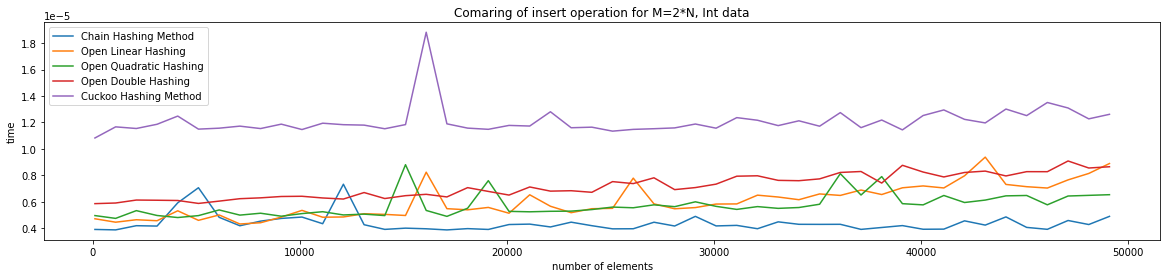

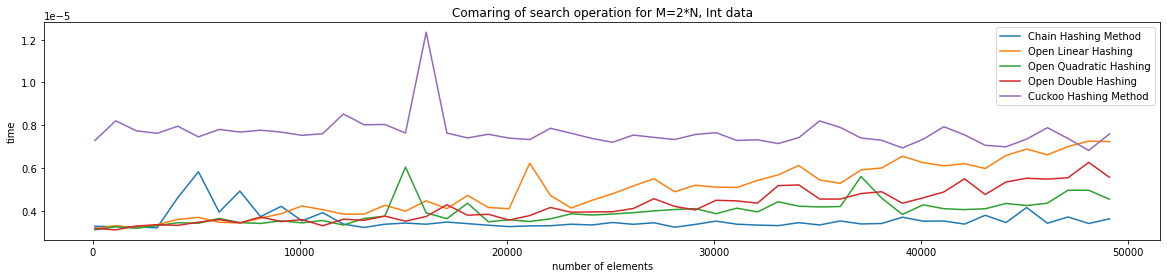

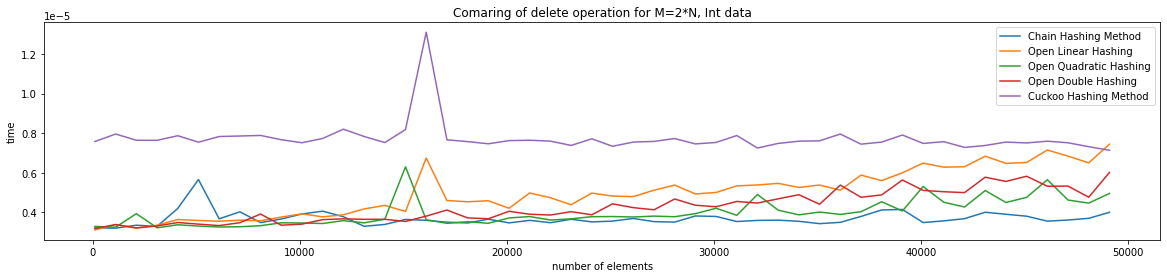

In [117]:
plot_time_by_operation(all_results, 'insert', limits, title_case)
plot_time_by_operation(all_results, 'search', limits, title_case)
plot_time_by_operation(all_results, 'delete', limits, title_case)

In [118]:
limits = (100, 50001, 1000)
all_results = measure_time_all_algorithms(limits=limits, size_coeff=1)
title_case = 'M=N, Int data'

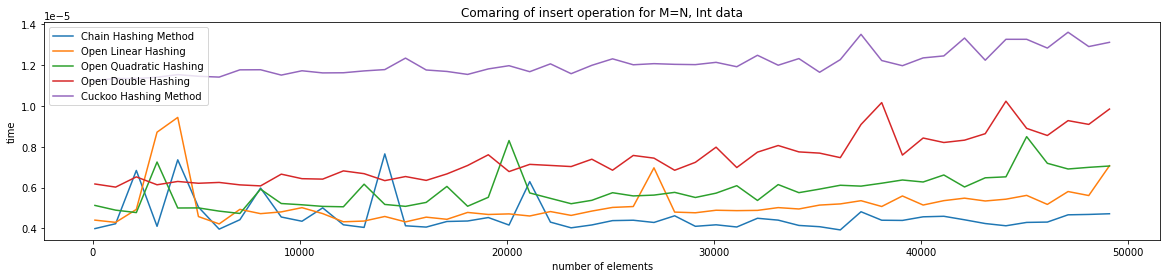

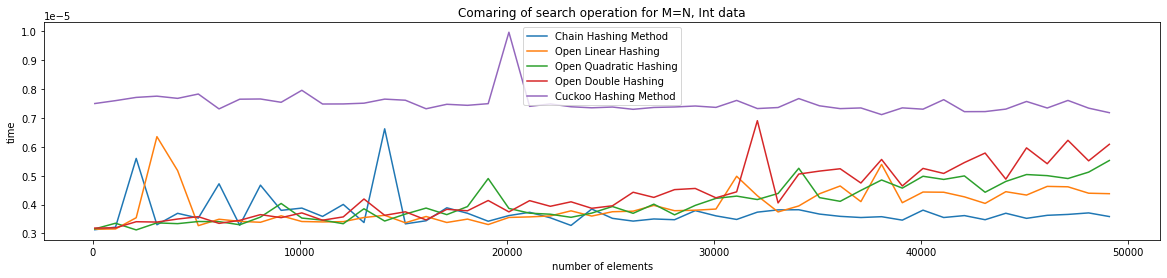

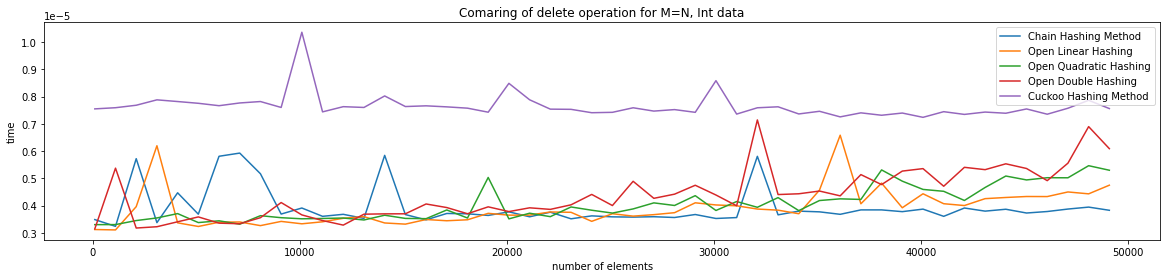

In [119]:
plot_time_by_operation(all_results, 'insert', limits, title_case)
plot_time_by_operation(all_results, 'search', limits, title_case)
plot_time_by_operation(all_results, 'delete', limits, title_case)

In [163]:
limits = (100, 50001, 1000)
all_results = measure_time_all_algorithms(limits=limits, size_coeff=0.5)
title_case = 'M=1/2N, Int data'

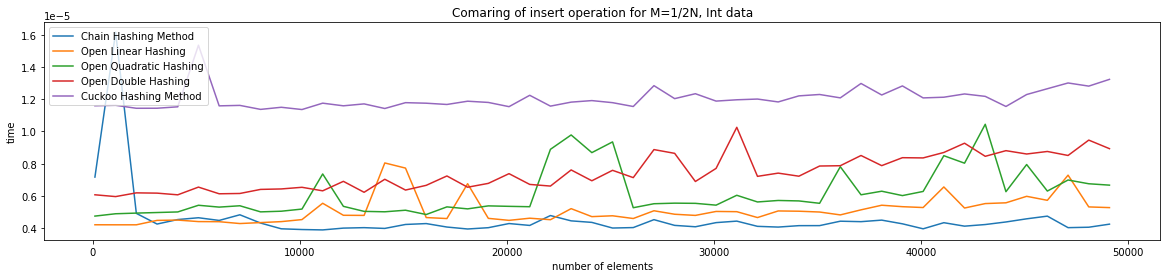

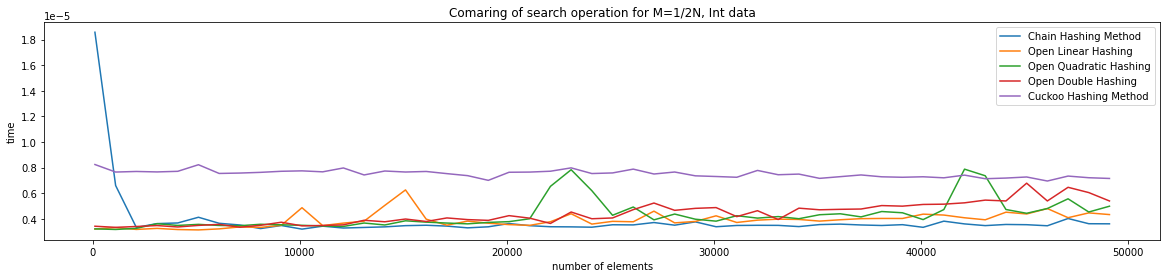

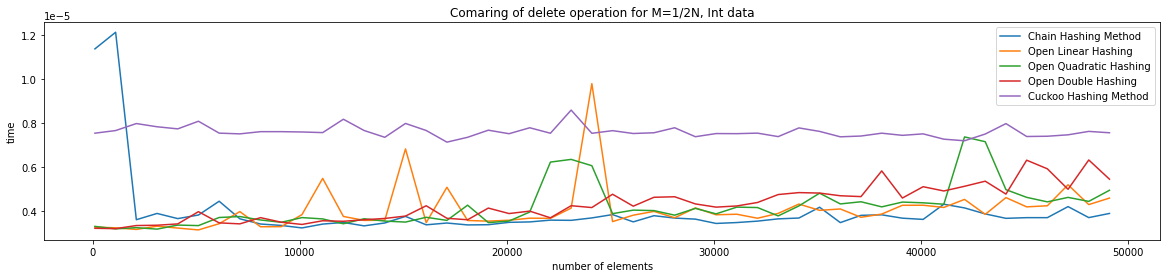

In [164]:
plot_time_by_operation(all_results, 'insert', limits, title_case)
plot_time_by_operation(all_results, 'search', limits, title_case)
plot_time_by_operation(all_results, 'delete', limits, title_case)

#Вывод
 Как и предполагалось, на случаных данных простые методы, такие как метод цепочек и открытой адресации показывают себя лучше, чем метод кукушки. 
 
Отметим, что если провести эксперимент на реальных данных (т.е. неравномерно распределенных данных) мы получим другие результаты. 
